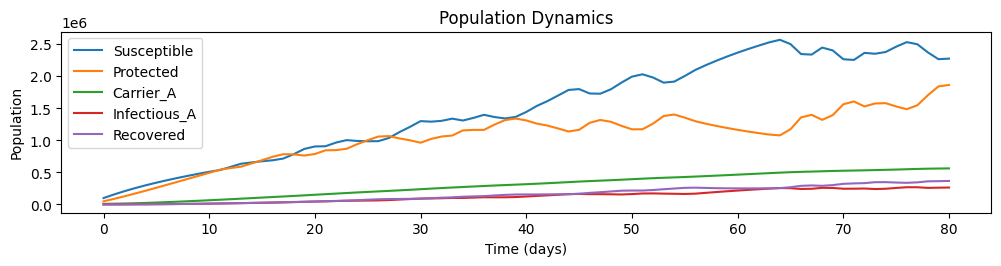

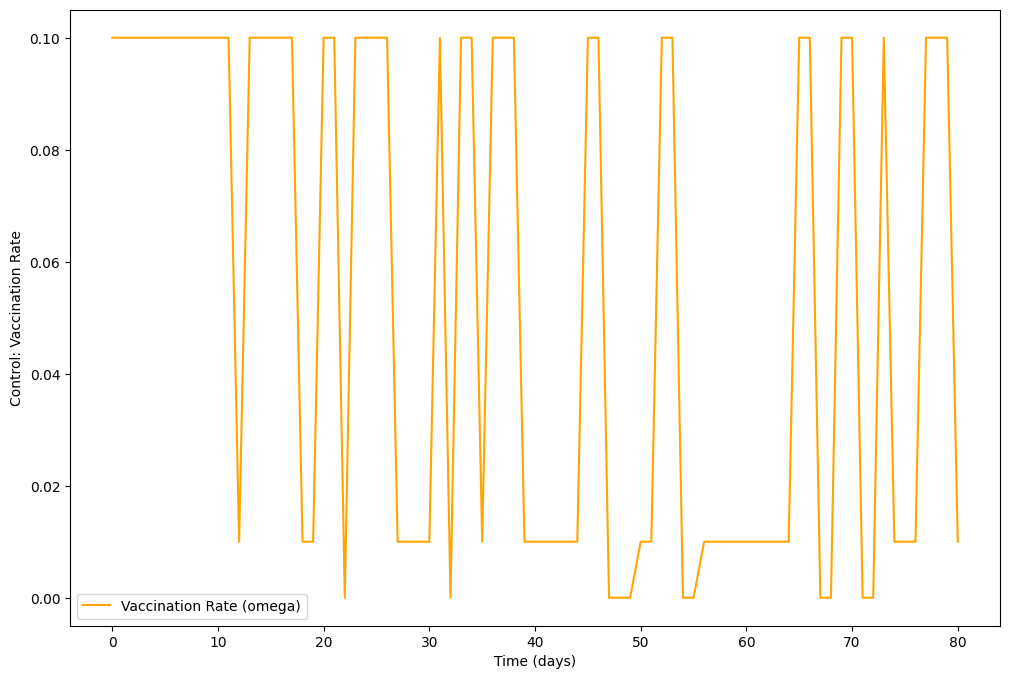

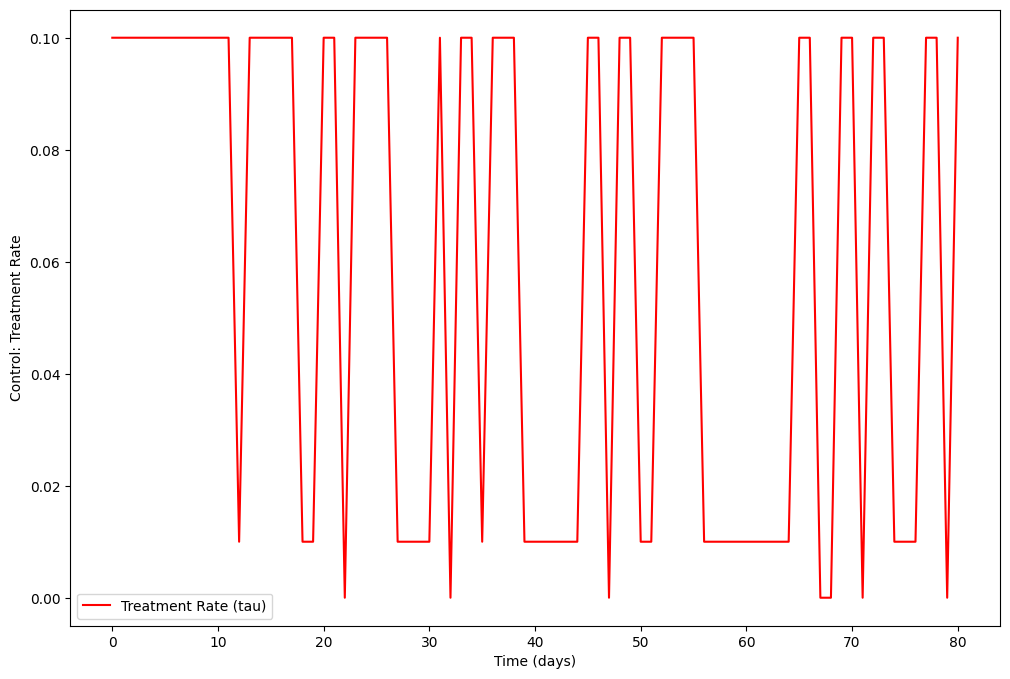

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Parameters
Lambda = 1e5  # Recruitment rate
pi = 0.3      # Proportion of newborns directly protected
eta = 0.1     # Rate of loss of immunity
varphi = 0.05 # Rate of loss of protection
mu = 0.01     # Natural mortality rate
lambda_A = 0.02 # Rate of acquiring carrier status
theta_A = 0.5  # Transition rate from protected to carrier
q_A = 0.1      # Proportion of carriers becoming infectious
gamma_A = 0.7  # Fraction of carriers progressing to infectious
delta_1 = 0.05 # Recovery rate for treated infectious individuals
d_A = 0.03     # Disease-induced mortality
initial_conditions = [1e5, 5e4, 1e4, 1e3, 0]  # Initial [S, P, C_A, I_A, R]

T = 80  # Simulation time
t_eval = np.linspace(0, T, T+1)  # Time points for evaluation

# ODE system
def disease_model(t, y, controls, params):
    S, P, C_A, I_A, R = y
    omega, tau = controls(t)  # Control functions (vaccination and treatment rates)
    Lambda, pi, eta, varphi, mu, lambda_A, theta_A, q_A, gamma_A, delta_1, d_A = params

    dSdt = (1 - pi) * Lambda + eta * R + varphi * P - (mu + omega + lambda_A) * S
    dPdt = pi * Lambda + omega * S - (varphi + mu + theta_A * lambda_A) * P
    dCAdt = lambda_A * S + lambda_A * theta_A * P - (mu + q_A) * C_A
    dIAdt = q_A * gamma_A * C_A - (mu + d_A + delta_1 + tau) * I_A
    dRdt = (delta_1 + tau) * I_A + q_A * (1 - gamma_A) * C_A - (mu + eta) * R

    return [dSdt, dPdt, dCAdt, dIAdt, dRdt]

# Cost function
def cost_function(controls, solution, params, control_costs):
    # Transpose solution to get time series for each compartment
    solution = solution.T
    # Now S, P, C_A, I_A, R will be arrays representing the population dynamics over time
    S, P, C_A, I_A, R = solution[:, 0], solution[:, 1], solution[:, 2], solution[:, 3], solution[:, 4]
    # Evaluate controls over the time points to get omega and tau values
    omega_vals, tau_vals = controls(t_eval) # This line is changed
    # Now you can use np.trapz to calculate the cost of controls
    cost_infectious = np.trapz(I_A, dx=1)  # Minimize infectious individuals
    cost_controls = np.trapz(omega_vals**2 + tau_vals**2, dx=1) * control_costs  # Quadratic cost of controls # This line is changed
    return cost_infectious + cost_controls

# Control functions
def controls(t, omega_vals, tau_vals):
    omega = np.interp(t, t_eval, omega_vals)
    tau = np.interp(t, t_eval, tau_vals)
    return omega, tau

# Objective function for optimization
def objective(u):
    omega_vals = u[:len(t_eval)]
    tau_vals = u[len(t_eval):]
    control_func = lambda t: controls(t, omega_vals, tau_vals)
    params = [Lambda, pi, eta, varphi, mu, lambda_A, theta_A, q_A, gamma_A, delta_1, d_A]

    # Solve the ODE system
    sol = solve_ivp(
        lambda t, y: disease_model(t, y, control_func, params),
        [0, T], initial_conditions, t_eval=t_eval, vectorized=True
    )
    # Calculate the cost
    return cost_function(control_func, sol.y, params, control_costs=0.1)

# Initial guess for controls
omega0 = np.zeros_like(t_eval) + 0.01  # Initial vaccination rate
tau0 = np.zeros_like(t_eval) + 0.01    # Initial treatment rate
u0 = np.concatenate([omega0, tau0])

# Bounds for controls
bounds = [(0, 0.1)] * len(t_eval) + [(0, 0.1)] * len(t_eval)

# Minimize the objective
result = minimize(objective, u0, bounds=bounds, method='L-BFGS-B')

# Extract optimal controls and simulate dynamics
u_optimal = result.x
omega_optimal = u_optimal[:len(t_eval)]
tau_optimal = u_optimal[len(t_eval):]

control_func_opt = lambda t: controls(t, omega_optimal, tau_optimal)

# Simulate with optimal controls
params = [Lambda, pi, eta, varphi, mu, lambda_A, theta_A, q_A, gamma_A, delta_1, d_A]
solution = solve_ivp(
    lambda t, y: disease_model(t, y, control_func_opt, params),
    [0, T], initial_conditions, t_eval=t_eval, vectorized=True
)

# Extract compartments
S, P, C_A, I_A, R = solution.y

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t_eval, S, label='Susceptible')
plt.plot(t_eval, P, label='Protected')
plt.plot(t_eval, C_A, label='Carrier_A')
plt.plot(t_eval, I_A, label='Infectious_A')
plt.plot(t_eval, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('Population Dynamics')
plt.savefig('population_dynamics.png')  # Save the first plot
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(t_eval, omega_optimal, label='Vaccination Rate (omega)', color='orange')
plt.xlabel('Time (days)')
plt.ylabel('Control: Vaccination Rate')
plt.legend()
plt.savefig('treatment_rate.png')  # Save the second plot
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t_eval, tau_optimal, label='Treatment Rate (tau)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Control: Treatment Rate')
plt.legend()
plt.savefig('treatment_rate.png')  # Save the third plot

#plt.tight_layout()
plt.show()
